# Example notebook using Qililab

In [1]:
import os
from pathlib import Path

from qibo.gates import M, X
from qibo.models.circuit import Circuit
from qiboconnection.api import API, ConnectionConfiguration

from qililab import Experiment, ExperimentOptions, ExperimentSettings, build_platform
from qililab.typings.enums import Parameter
from qililab.typings.loop import LoopOptions
from qililab.utils.loop import Loop

%matplotlib widget

TypeError: non-default argument 'frequency' follows default argument

In [2]:
fname = os.path.abspath("")
os.environ["RUNCARDS"] = str(Path(fname) / "runcards")
os.environ["DATA"] = str(Path(fname) / "data")

## Set the Remote Connection for Live Plotting

Please replace the `test_username` and the `test_key` arguments of the API configuration:

In [3]:
configuration = ConnectionConfiguration(username="amitjans", api_key="dda9f46d-790f-460e-88c5-71792c76fa44")
connection = API(configuration=configuration)

[qibo-connection] 0.7.2|INFO|2023-03-23 11:32:59]: Storing personal qibo configuration...
INFO:qiboconnection.config:Storing personal qibo configuration...


## Load a platform

In [4]:
runcard_name = "sauron_soprano"
platform = build_platform(name=runcard_name, connection=connection)

[qililab] [0.16.1|INFO|2023-03-23 11:33:04]: Building platform
INFO:qililab.config.config:Building platform


### Platform Chip

In [5]:
print(platform.chip)

Chip None with 1 qubits and 2 ports: 

 * Port 0: ----|qubit|----
 * Port 1: ----|resonator|----



### Platform Buses

In [6]:
print(platform.schema)

Bus 0:  -----|QCM|--|rs_2|------|qubit|----
Bus 1:  -----|QRM|--|rs_1|------|resonator|----


## Connect to a Platform

In [ ]:
# Connect to all instruments of the platform and block the connection for other users
platform.connect(manual_override=False)  # if manual_override=True, it surpasses any blocked connection
platform.initial_setup()  # Sets all the values of the Runcard to the connected instruments
platform.turn_on_instruments()  # Turns on all instruments

## Create an experiment

### Create the circuit associated with the experiment

In [6]:
# Define Circuit to execute
circuit = Circuit(1)
circuit.add(X(0))
circuit.add(M(0))

MeasurementResult(qubits=(0,), nshots=0)

### Create loops over parameter values (optional)

In [7]:
lo_freq_loop = Loop(
    alias="drive_line_bus",
    parameter=Parameter.LO_FREQUENCY,
    options=LoopOptions(start=6.0e09, stop=6.5e09, num=10),
)

### Initialize the Experiment

In [8]:
settings = ExperimentSettings(
    hardware_average=1000,
    repetition_duration=200_000,
    software_average=1,
)

options = ExperimentOptions(
    loops=[lo_freq_loop],  # loops to run the experiment
    settings=settings,  # experiment settings
    name="experiment_name",  # name of the experiment (it will be also used for the results folder name)
    plot_y_label=None,  # plot y-axis label
)

sample_experiment = Experiment(
    platform=platform,  # platform to run the experiment
    circuits=[circuit],  # circuits to run the experiment
    options=options,  # experiment options
)

### Translate the circuit into pulses and build the Execution object

In [9]:
sample_experiment.build_execution()

### Draw pulses to be sent

/Users/albertmitjans/Developer/qililab/src/qililab/pulse/pulse.py:46: UserWarning: No frequency found for pulse pulse. Setting frequency to 0.
  warnings.warn(f"No frequency found for pulse {self.name}. Setting frequency to 0.")
/Users/albertmitjans/Developer/qililab/src/qililab/pulse/pulse.py:46: UserWarning: No frequency found for pulse readout_pulse. Setting frequency to 0.
  warnings.warn(f"No frequency found for pulse {self.name}. Setting frequency to 0.")


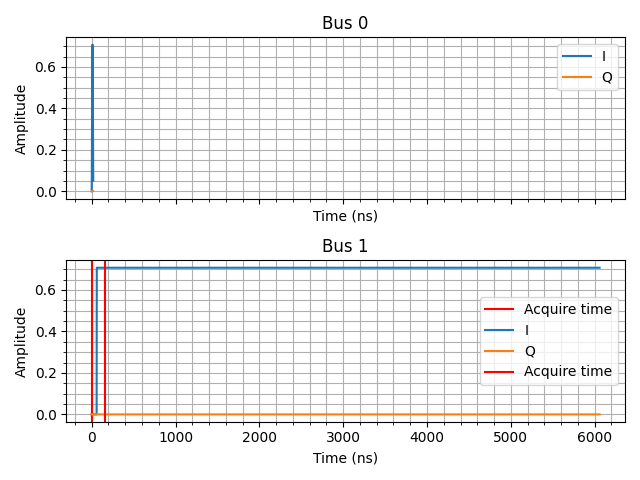

In [13]:
figure = sample_experiment.draw()

## Run the experiment

In [14]:
results = sample_experiment.run()

In [ ]:
print(results)

## Disconnect from a Platform

- Disconnect all instruments specified in the loaded platform
- Turns off the instruments only when explicitly specified (by default is set to False)

In [8]:
platform.disconnect()

[qibo-connection] 0.7.2|INFO|2023-03-23 11:25:34]: Device Galadriel Qblox rack released.
INFO:qiboconnection.config:Device Galadriel Qblox rack released.
[qililab] [0.16.1|INFO|2023-03-23 11:25:34]: Already disconnected from the instruments
INFO:qililab.config.config:Already disconnected from the instruments
